# Detection of anomalies in a time series of Kd measurements
---------------
### Authors
Carlos Rodero García <br>
Raul Bardaji  <br>
Jaume Piera  <br>
Thomas Jackson  <br>

### Creation Date
14/08/2020


### License
This text and resulting plots are available under Creative Commons BY-NC licence (https://creativecommons.org/licenses/by-nc/4.0/). 
To cite this page, please use the following: <br> 
Rodero, C., Bardají, R., Jackson, T. and Piera, J. (2020). Detection of anomalies in a time series of Kd measurements. _In_: Jackson, T., Rodero, C., Bardají, R., Piera, J., De Keukelaere, L., Simis, S. (2020). D6.2 Demonstration of automated anomaly detection and data flagging. Deliverable report of project H2020 MONOCLE (grant 776480). doi: 10.5281/zenodo.4043552

This license does not cover the underlying data and models, please refer to the cited source for their respective licensing. 


## Introduction
 
The transparency of a water body is an important property that can be used to assess the bodies environmental status.  This is due to the strong optical impact of different water quality related components (such as the presence of phytoplankton, organic matter and sediment concentrations). One parameter to assess the water transparency is the diffuse attenuation coefficient.  The diffuse attenuation coefficient has a unit of m$^{-1}$ and is the reduction in irradiance for a given distance in the medium.

Instruments that measure irradiance at multiple depths can therefore be used to calculate Kd. The KdUINO instrument is a relaitvely low-cost instrument for such data aquisition and was deployed as part of a field campaign at Loch Leven in Scotland within the MONOCLE project (https://www.monocle-h2020.eu).  Data from this deployment is used in the demonstration below.
 
It is important that only high quality data is used in scientific analysis, to avoid spurious results and interpretation.  Given that the KdUINO is a relatively low cost instrument that might be deployed for extended periods of time it is important that we can perform checks for drift in the sensor or anomalous results within a time series.  This is what is demonstrated below.




### Data description


To begin with we are going to integrate the KdUNIO measurements into 15 minute bins (from 8/22/2018 11:50:00 to 13:41:00).  This integration should help improve the signal to noise ratio by removing the influence of short term noise in the data.

The raw data were sampled at 1Hz so a 15 minute integration involves the binning and averaging of 900 irradiance measurement.
 
The raw data is sampled at 11 depths (0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0, and 6.0 meters).


### Code dependences and working environment

The following code imports several modules that should be installed previously
We recommend to create a virtual environment with Virtualenv/Venv or Anaconda, and then add this Virtual Environment to this Jupyter Notebook. 
This is the list of the requirements we need to install in this virtual environment:
- cycler==0.10.0
- kiwisolver==1.2.0
- matplotlib==3.2.1
- numpy==1.18.3
- pandas==1.0.3
- pyparsing==2.4.7
- python-dateutil==2.8.1
- pytz==2019.3
- scipy==1.4.1
- seaborn==0.10.0
- six==1.14.0

[Click here to see a tutorial about how to use Virtual Environments in Jupyter Notebook](https://janakiev.com/blog/jupyter-virtual-envs/)

## Code and results

#### Import libraries and raw data

In [25]:
from datetime import datetime
import re
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt


# import data and convert to Dataframe
url="https://zenodo.org/record/3757669/files/data_buoy.csv?download=1"
df = pd.read_csv(filepath_or_buffer=url, sep=";", index_col="TIME")

# index to datetime
df.index = pd.to_datetime(df.index)


In [26]:
'''Get only CLEAR columns (we will use total irradiance attentuation 
   rather than attentuation for a given section of the spectrum)'''

df_clear = df.filter(regex=("CLEAR.*"))
print(df_clear)

                     CLEAR_0.5  CLEAR_1.0  CLEAR_1.5  CLEAR_2.0  CLEAR_2.5  \
TIME                                                                         
2018-08-22 11:50:00     2806.0      744.0      103.0       32.0       19.0   
2018-08-22 11:50:00     2599.0      941.0       94.0       33.0       20.0   
2018-08-22 11:50:00     1793.0      795.0       92.0       32.0       18.0   
2018-08-22 11:50:00     1323.0      808.0      100.0       37.0       17.0   
2018-08-22 11:50:00     1774.0      933.0       98.0       42.0       20.0   
...                        ...        ...        ...        ...        ...   
2018-08-22 14:59:00     2558.0     1210.0      310.0       92.0       48.0   
2018-08-22 14:59:00     3196.0     1172.0      287.0       85.0       47.0   
2018-08-22 14:59:00     3794.0     1066.0      315.0       86.0       43.0   
2018-08-22 14:59:00     2010.0     1105.0      313.0       99.0       43.0   
2018-08-22 14:59:00     3382.0     1239.0      344.0      101.0 

#### create functions

First function will get all depths measured with Kduino.

Second function is for easy and repeatable plotting.

In [27]:
# get depths

def get_depths():
    """
    Find all depths that are included in column names
    and return a list of this depths
    
    Returns
    -------
        depth_list: list
            list of depths extracted from column names

    """
    # get list of columns values
    pre_depth_list = str(df_clear.columns)
    # extract numbers of this values
    depth_list = re.findall(r'\d+\.\d+', pre_depth_list)
    # convert numbers to float
    depth_list = [float(item) for item in depth_list]
    # convert list to a Series 
    # depth_list = pd.Series(depth_list)
    
    return depth_list

# scatter plot of counts between 2 defined times
def scatter_plot_time_lapse(dstart, dend, parameter, title):
    """
    Return Scatter plot of parameter in specific time
    Parameters
    ----------
        dstart: datetime
            Start datetime, we use it to specify left limit axes of plot
        dend: datetime
            End datetime, we use it to specify right limit axes of plot
        parameter: string
            Parameter of dataframe we want to plot
    Returns
    -------
        plt.show(): matplotlib object
            Display the figure
    """

    plt.figure(figsize=(12, 8))
    # slice time with mask
    mask_m0 = (df.index >= start_date_time) & (df.index <= end_date_time)
    df_clear_m0 = df_clear.loc[mask_m0]
    # scatter plot between time and CLEAR_0.5
    ax = sns.scatterplot(x=df_clear_m0.index, y=df_clear_m0[parameter])
    # Set the `xlim`
    ax.set_xlim(dstart, dend)
    ax.set_title(title)
    ax.set_ylabel('counts')
    # return the plot
    
    return plt.show()


#### Test to see if we can detect the variability of counts measured in one time lapse in the full spectre at 0.5m depth

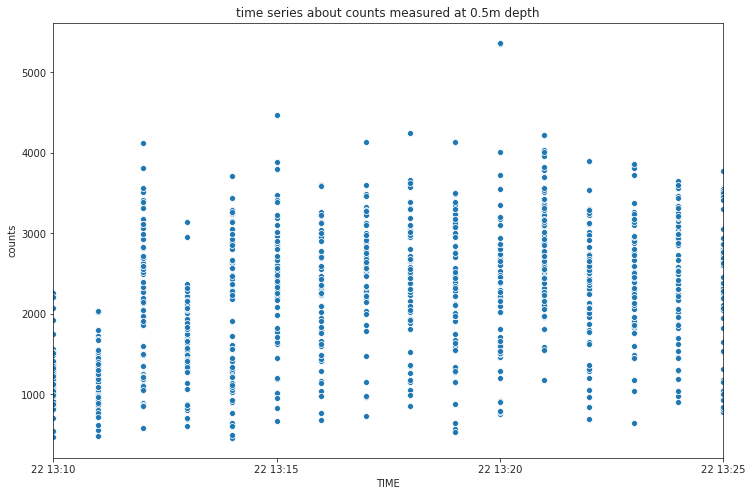

In [28]:

start_date_time = '08/22/2018 13:10:00'
end_date_time = '8/22/2018 13:25:00'
parameter = 'CLEAR_0.5'

dstart = datetime.strptime(start_date_time, '%m/%d/%Y %H:%M:%S')
dend = datetime.strptime(end_date_time, '%m/%d/%Y %H:%M:%S')

scatter_plot_time_lapse(dstart, dend, parameter, 'time series about counts measured at 0.5m depth')

#### Create functions for slicing the dataframe for time ranges and calculate stats for time bins

We are going to integrate over a set range of times:

| Start time| End time |
| --- | --- |
| 11:50:00 | 12:05:00 |
| 12:06:00 | 12:21:00 |
| 12:22:00 | 12:37:00 |
| 12:38:00 | 12:53:00 |
| 12:54:00 | 13:09:00 |
| 13:10:00 | 13:25:00 |
| 13:26:00 | 13:41:00 |


and get the Kd and coeffient of determination for each time interval.

In [29]:
# function to slice time of dataframe
def slice_df(start_date_time, end_date_time, df_clear):
    """
    Function to slice time of dataframe in the specific range using mask    
    Parameters
    ----------
        start_date_time: datetime
            Start datetime of our range
        end_date_time: datetime
            End datetime of our range
        df_clear: Pandas Dataframe
            Dataframe filtered by full spectral columns            
    Returns
    -------
        df_clear: Pandas Dataframe
            Dataframe filtered by full spectral columns and time
    """
    mask = (df_clear.index >= start_date_time) & (df_clear.index <= end_date_time)
    df_clear = df_clear.loc[mask]
    
    return df_clear

# calculate mean standard deviation and log
def calc_df(df_clear):
    """
    Function to calculate mean, standard deviation and log of counts    
    Parameters
    ----------
        df_clear: Pandas Dataframe
            Dataframe filtered by full spectral columns and time
    Returns
    -------
        df_clear: Pandas Dataframe
            Dataframe with new columns of "mean", "stdev" (standard deviation), and "log"
    """
    df_clear['mean'] = df_clear.mean(axis=1)
    df_clear['stdev'] = df_clear.std(axis=1)
    log_row = np.log(df_clear['mean'])
    df_clear['log_row'] = log_row
    
    return df_clear

#### Create plotting function to show estimate of Kd from data

In [30]:
def kd_plot(start_date_time, end_date_time, data_subset,x, y, slope, intercept, r_value, axs):
    '''Function to plot Kd and linear regression in a figure
    Parameters
    ----------
        start_date_time: datetime
        Start datetime, we use it to specify left limit axes of plot
        end_date_time: datetime
        End datetime, we use it to specify right limit axes of plot
        x: list
        List of depths
        y: list
        List of log values of counts for each depth
        slope: float
        The \"m\" number of the equation of straight line written as \"y = mx + b\"
        Represents the negative of Kd
        intercept: float
        The \"b\" number of the equation of straight line written as \"y = mx + b\"
        The point where the line crosses the vertical y-axis
        r_value: float
        coefficient of determination
    Returns
    -------
        plt.show(): matplotlib object
        Display the figure
'''
    ax1 = sns.regplot(x=x, y=y, data=data_subset, color='b',
        line_kws={'label':" y = {0:.4f}x + {1:.4f} ".format(slope, intercept)}, ax=axs)
    ax1.text(2.65, 2.5, "R\u00B2 = {0:.4f}".format(r_value**2),bbox=dict(facecolor='none',edgecolor='grey',boxstyle='square'), fontsize=10)

    # plot legend
    ax1.legend(fontsize=16)
    start_time = start_date_time.split(" ")[1]
    end_time = end_date_time.split(" ")[1]
    ax1.set_title('Kd estimate from {} to {}'.format(start_time, end_time), fontsize=10)
    ax1.set_ylabel('log counts', fontsize=16)
    ax1.set_xlabel('depths (m)', fontsize=16)
    
    return 

#### test calculation and plot for time interval 1
11:50:00 to 12:05:00

intercept:  8.477485905152536
slope:  -1.9937270603451875


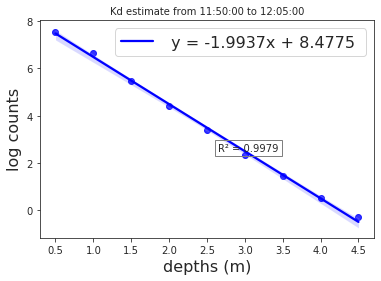

In [31]:
# time 1
start_date_time = '8/22/2018 11:50:00'
end_date_time = '8/22/2018 12:05:00'

# slice time of dataframe using mask
df_clear_m1 = slice_df(start_date_time, end_date_time, df_clear)

# transpose the rows and columns in dataframe to get values for each depth
df_clear_m1 = df_clear_m1.transpose()

# get depths
df_clear_m1["depths"] = get_depths()

# calculate mean standard deviation and log
df_clear_m1 = calc_df(df_clear_m1)

# get x and y for plot
x1 = df_clear_m1['depths'][0:9]
y1 = df_clear_m1['log_row'][0:9]

# get coeffs of linear fit
summary_stats=[]
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1, y1)
summary_stats.append([slope1, intercept1, r_value1, p_value1, std_err1])
print('intercept: ',intercept1)
print('slope: ',slope1)
# plot data and a linear regression model fit
fig,axs=plt.subplots(nrows=1, ncols=1)
kd_plot(start_date_time, end_date_time, df_clear_m1, x1, y1, slope1, intercept1, r_value1, axs)
plt.show()

In [32]:
#For a more detailed breakdown of the relationship we can use sm.OLS
import statsmodels.api as sm
x1 = df_clear_m1['depths'][0:9]
y1 = df_clear_m1['log_row'][0:9]
x1=sm.add_constant(x1)
# get coeffs of linear fit
results = sm.OLS(y1, x1).fit()
results.summary()

/users/rsg/thja/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_row   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3400.
Date:                Mon, 17 Aug 2020   Prob (F-statistic):           1.15e-10
Time:                        15:13:39   Log-Likelihood:                 6.5555
No. Observations:                   9   AIC:                            -9.111
Df Residuals:                       7   BIC:                            -8.717
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4775      0.096     88.114      0.000       8.250       8.705
depths        -1.9937      0.034    -58.306      0.000      -2.075      -1.913
==============================================================================
Omnibus:                        0.888   Durbin-Watson:                   1.023
Prob(Omnibus):                  0.641   Jarque-Bera (JB):                0.696
Skew:                           0.536   Prob(JB):                        0.706
Kurtosis:                       2.160   Cond. No.                         6.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### now for all the other time intervals
 12:06:00 - 12:41:00 in 15 minute chunks

('8/22/2018 12:06:00', '8/22/2018 12:21:00')
('8/22/2018 12:22:00', '8/22/2018 12:37:00')
('8/22/2018 12:38:00', '8/22/2018 12:53:00')
('8/22/2018 12:54:00', '8/22/2018 13:09:00')
('8/22/2018 13:10:00', '8/22/2018 13:25:00')
('8/22/2018 13:26:00', '8/22/2018 13:41:00')


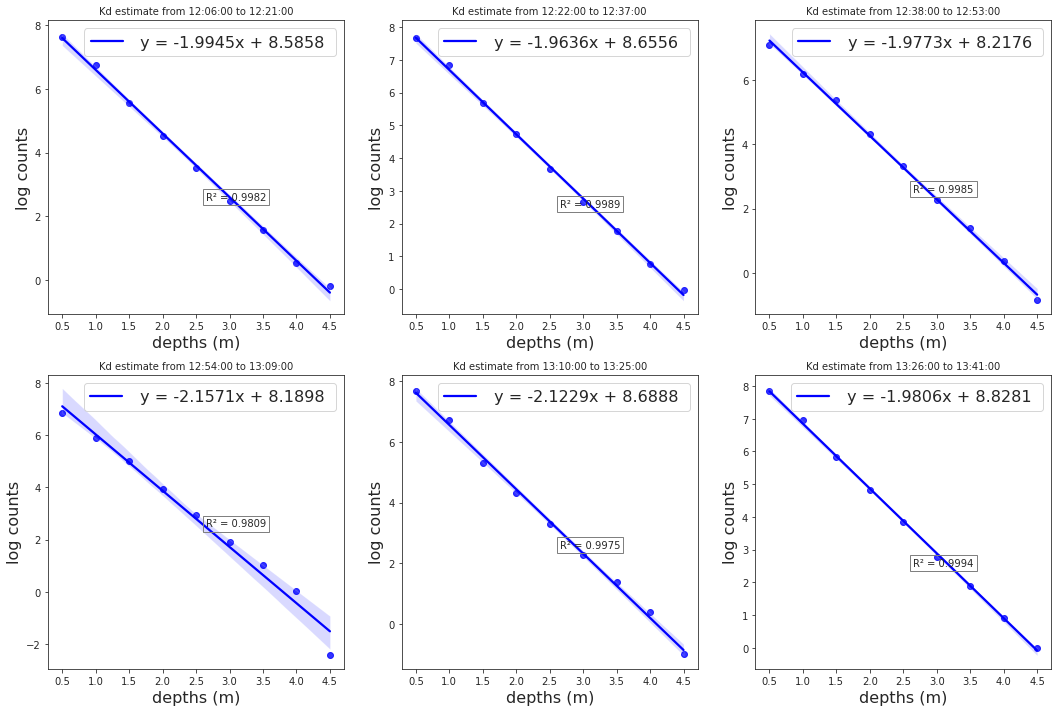

In [33]:
# time 2 onwards
time_sets=[('8/22/2018 12:06:00','8/22/2018 12:21:00'), ('8/22/2018 12:22:00','8/22/2018 12:37:00'), 
    ('8/22/2018 12:38:00','8/22/2018 12:53:00'), ('8/22/2018 12:54:00','8/22/2018 13:09:00'),
    ('8/22/2018 13:10:00','8/22/2018 13:25:00'), ('8/22/2018 13:26:00','8/22/2018 13:41:00'),]

fig, axes=plt.subplots(ncols=3, nrows=2, figsize=(15,10))
for t,time_set in enumerate(time_sets):
    print(time_set)
    # slice time of dataframe using mask
    start_date_time, end_date_time=time_set[0],time_set[1]
    df_clear_time_set = slice_df(start_date_time, end_date_time, df_clear)
    # transpose the rows and columns in dataframe to get values for each depth
    df_clear_time_set = df_clear_time_set.transpose()
    # get depths
    df_clear_time_set["depths"] = get_depths()
    # calculate mean standard deviation and log
    df_clear_time_set = calc_df(df_clear_time_set)
    # get x and y for plot
    x2 = df_clear_time_set['depths'][0:9]
    y2 = df_clear_time_set['log_row'][0:9]
    # get coeffs of linear fit
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2, y2)
    summary_stats.append([slope2, intercept2, r_value2, p_value2, std_err2])
    # plot data and a linear regression model fit
    kd_plot(start_date_time, end_date_time, df_clear_time_set,x2, y2, slope2, intercept2, r_value2, axes.flat[t])
    
plt.tight_layout()
summary_stats=pd.DataFrame(summary_stats, columns=["slope", "intercept", "r_value", "p_value", "std_err"])

#### Identifying the anomaly
Here it can be seen that for the timespan 12:54 to 13:09 (first plot of the second row above) there is something strange going on.  The lowest point (at 4.5m) appears to be significantly off axis with respect to the rest.  This is reflected in the summary stats as this time bin has a significantly higher std_err.

In [34]:
summary_stats['std_err']



0    0.034194
1    0.031818
2    0.025009
3    0.028699
4    0.113620
5    0.039768
6    0.018625
Name: std_err, dtype: float64

We will now create a function that will interrogate the irradiance data and such that it can automatically identify such anomalies in a dataset.  This will involve 2 tests:

- The first is applying a threshold on the std_err in the data that is input to the Kd estimate.
- The second is looking for a significant change in the Kd estimate for different subsets of the depth profile (meaning either an error or an extremely strong vertical gradient in optical properties, for which the device is not suitable).


In [35]:
def Kd_anomaly_checker(depths, log_irradiance, threshold, subset_size):

    # using all the data test against the threshold
    x = depths
    y = log_irradiance
    
    # get coeffs of linear fit
    results = sm.OLS(y1, x1).fit()
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    if std_err>threshold:
        print('anomaly_flag1 raised')
        anomaly_flag_1=True
    else:
        anomaly_flag_1=False
    if (subset_size % 2) == 0 or subset_size<3:
        print("subset size must be an odd integer >= 3")
        raise ValueError 
    last_point=len(x)-1
    #Now see if the relationship is consistent with different subsets
    x_1, y_1=x[0:subset_size], y[0:subset_size]
    x_1=sm.add_constant(x_1)
    res1=sm.OLS(y_1, x_1).fit()
    #print(res1.summary())
    x_2, y_2=x[int(last_point/2-np.floor(subset_size/2)):int(last_point/2+np.ceil(subset_size/2))], y[int(last_point/2-np.floor(subset_size/2)):int(last_point/2+np.ceil(subset_size/2))]
    x_2=sm.add_constant(x_2)
    res2=sm.OLS(y_2, x_2).fit()
    #print(res2.summary())
    x_3, y_3=x[last_point-subset_size:], y[last_point-subset_size:]
    x_3=sm.add_constant(x_3)
    res3=sm.OLS(y_3, x_3).fit()
    #print(res3.summary())
    all_res=[res1, res2, res3]
    smin=np.argmin([res1.params['depths'],res2.params['depths'],res3.params['depths']])
    smax=np.argmax([res1.params['depths'],res2.params['depths'],res3.params['depths']])

    #For z stat use see Paternoster, Raymond, et al. "Using the correct statistical test for the equality of regression coefficients." Criminology 36.4 (1998): 859-866.
    z=(all_res[smax].params['depths']-all_res[smin].params['depths'])/(np.sqrt(all_res[smax].bse['depths']**2+all_res[smin].bse['depths']**2))
    #print(z)
    # Significant at 95% on a 1-tail test?
    if z> 1.6448536269514722:
        print('anomaly_flag2 raised')
        anomaly_flag_2=True
    else:
        anomaly_flag_2=False
    print('')
    return [anomaly_flag_1, anomaly_flag_2]
    

In [36]:
Kd_anomalies=[]
Kd_anomalies.append(Kd_anomaly_checker(x1['depths'], y1, 0.1, 7))
for t,time_set in enumerate(time_sets):
    print(time_set)
    # slice time of dataframe using mask
    start_date_time, end_date_time=time_set[0],time_set[1]
    df_clear_time_set = slice_df(start_date_time, end_date_time, df_clear)
    # transpose the rows and columns in dataframe to get values for each depth
    df_clear_time_set = df_clear_time_set.transpose()
    # get depths
    df_clear_time_set["depths"] = get_depths()
    # calculate mean standard deviation and log
    df_clear_time_set = calc_df(df_clear_time_set)
    # get x and y for plot
    x = df_clear_time_set['depths'][0:9]
    y = df_clear_time_set['log_row'][0:9]
    Kd_anomalies.append(Kd_anomaly_checker(x, y, 0.1, 7))
    
    


('8/22/2018 12:06:00', '8/22/2018 12:21:00')

('8/22/2018 12:22:00', '8/22/2018 12:37:00')

('8/22/2018 12:38:00', '8/22/2018 12:53:00')
anomaly_flag2 raised

('8/22/2018 12:54:00', '8/22/2018 13:09:00')
anomaly_flag1 raised
anomaly_flag2 raised

('8/22/2018 13:10:00', '8/22/2018 13:25:00')

('8/22/2018 13:26:00', '8/22/2018 13:41:00')



Above we can see that the time span '8/22/2018 12:54:00', '8/22/2018 13:09:00' has raised both anomaly flags and should perhaps be excluded from the analysis (or is at least worth further investigation).

Kd estimations
- 11:50:00 - 12:05:00

- 12:06:00 - 12:21:00

- 12:22:00 - 12:37:00

- 12:38:00 - 12:53:00

- 12:54:00 - 13:09:00

- 13:10:00 - 13:25:00

- 13:26:00 - 13:41:00

both_flags


No handles with labels found to put in legend.


(5.516208831054949, 0.04021747985172944)

<Figure size 432x288 with 0 Axes>

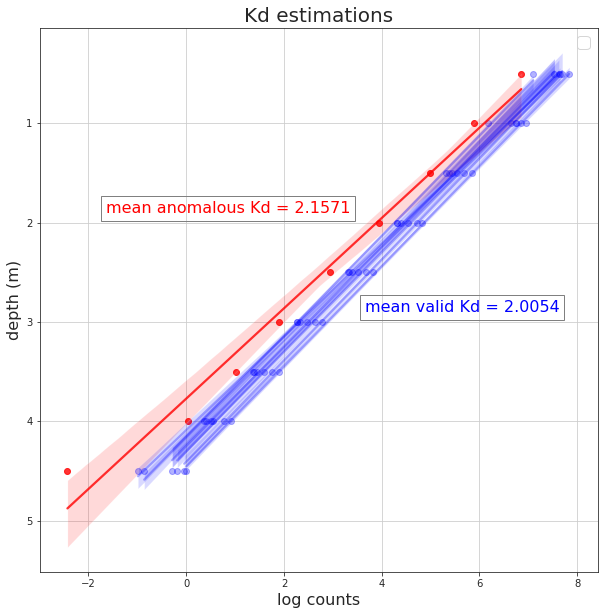

In [37]:
#  plot of all Kd estimations. In red, the linear regression of the anomaly.
plt.clf()
sns.set_style("ticks")
plt.figure(figsize=(10, 10))

all_time_sets=[('8/22/2018 11:50:00','8/22/2018 12:05:00'),('8/22/2018 12:06:00','8/22/2018 12:21:00'), ('8/22/2018 12:22:00','8/22/2018 12:37:00'), 
    ('8/22/2018 12:38:00','8/22/2018 12:53:00'), ('8/22/2018 12:54:00','8/22/2018 13:09:00'),
    ('8/22/2018 13:10:00','8/22/2018 13:25:00'), ('8/22/2018 13:26:00','8/22/2018 13:41:00'),]

both_flags=np.array(Kd_anomalies).all(axis=1)
ax = sns.regplot(x=y1, y=x1['depths'], color='b', scatter_kws={'alpha':0.0}, line_kws={'alpha':0.0})
for t,time_set in enumerate(all_time_sets):
    start_date_time, end_date_time=time_set[0],time_set[1]
    df_clear_time_set = slice_df(start_date_time, end_date_time, df_clear)
    df_clear_time_set = df_clear_time_set.transpose()
    df_clear_time_set["depths"] = get_depths()
    df_clear_time_set = calc_df(df_clear_time_set)
    x2 = df_clear_time_set['depths'][0:9]
    y2 = df_clear_time_set['log_row'][0:9]
    if both_flags[t]:
        print('both_flags')
        ax = sns.regplot(x=y2, y=x2, color='r', scatter_kws={'alpha':0.8}, line_kws={'alpha':0.8})
    else:
        ax = sns.regplot(x=y2, y=x2, color='b', scatter_kws={'alpha':0.3}, line_kws={'alpha':0.3})
# plot legend
ax.legend(fontsize=16)
plt.text(3.65, 2.9, "mean valid Kd = {0:.4f}".format(-1*np.mean(summary_stats['slope'][~both_flags])),color='blue', bbox=dict(facecolor='none',edgecolor='grey',boxstyle='square'), fontsize=16)
plt.text(-1.65, 1.9, "mean anomalous Kd = {0:.4f}".format(-1*np.mean(summary_stats['slope'][both_flags])),color='red', bbox=dict(facecolor='none',edgecolor='grey',boxstyle='square'), fontsize=16)

ax.set_title('Kd estimations', fontsize=20)
ax.set_ylabel('depth (m)', fontsize=16)
ax.set_xlabel('log counts', fontsize=16)
ax.grid(True)
ax.set_ylim(ax.get_ylim()[::-1])



## Summary of the code/operation demonstration



Here we have shown an example of the automated detection of potentially anomalous data within a time series of irradiance profiles.  The final plot shows the anomalous profile(s) in red where a profile has been identified as anomalous using only the data from that profile individually.  This means that without direct comaprison to the to the other profiles we have still identified the profile that sits aside from the other data taken within the time series.  The checks performed to flag this data were:
1. a threshold analysis of the noise within the profile data and 
2. a check for consistency of attenuation rates across the profile.